<a href="https://colab.research.google.com/github/Jaybhatt216/EIT/blob/main/Blackjack_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

starting episode 0
starting episode 100000
starting episode 200000
starting episode 300000
starting episode 400000
starting episode 500000
starting episode 600000
starting episode 700000
starting episode 800000
starting episode 900000
getting ready to test policy
win rate 0.4 loss rate 0.531 draw rate 0.069


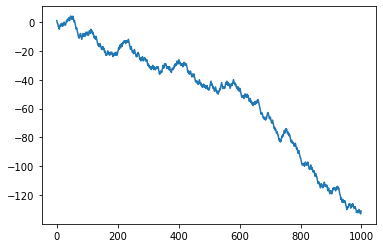

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt

if __name__ == '__main__':
    env = gym.make('Blackjack-v0')
    EPS = 0.05
    GAMMA = 1.0

    Q = {}
    agentSumSpace = [i for i in range(4, 22)]
    dealerShowCardSpace = [i+1 for i in range(10)]
    agentAceSpace = [False, True]
    actionSpace = [0, 1] # stick or hit

    stateSpace = []
    returns = {}
    pairsVisited = {}
    for total in agentSumSpace:
        for card in dealerShowCardSpace:
            for ace in agentAceSpace:
                for action in actionSpace:
                    Q[((total, card, ace), action)] = 0
                    returns[((total, card, ace), action)] = 0
                    pairsVisited[((total, card, ace), action)] = 0
                stateSpace.append((total, card, ace))
    
    policy = {}
    for state in stateSpace:
        policy[state] = np.random.choice(actionSpace)

    numEpisodes = 1000000
    for i in range(numEpisodes):
        statesActionsReturns = []
        memory = []
        if i % 100000 == 0:
            print('starting episode', i)
        observation = env.reset()
        done = False
        while not done:
            action = policy[observation]
            observation_, reward, done, info = env.step(action)
            memory.append((observation[0], observation[1], observation[2], action, reward))
            observation = observation_
        memory.append((observation[0], observation[1], observation[2], action, reward))    

        G = 0
        last = True
        for playerSum, dealerCard, usableAce, action, reward in reversed(memory):
            if last:
                last = False
            else:
                statesActionsReturns.append((playerSum, dealerCard, usableAce, action, G))
            G = GAMMA*G + reward

        statesActionsReturns.reverse()
        statesActionsVisited = []

        for playerSum, dealerCard, usableAce, action, G in statesActionsReturns:
            sa = ((playerSum, dealerCard, usableAce), action)
            if sa not in statesActionsVisited:
                pairsVisited[sa] += 1
                # incremental implementation
                # new estimate = 1 / N * [sample - old estimate]
                returns[(sa)] += (1 / pairsVisited[(sa)])*(G-returns[(sa)])
                Q[sa] = returns[sa]
                rand = np.random.random()
                if rand < 1 - EPS:
                    state = (playerSum, dealerCard, usableAce)
                    values = np.array([Q[(state, a)] for a in actionSpace ])
                    best = np.random.choice(np.where(values==values.max())[0])
                    policy[state] = actionSpace[best]
                else:
                    policy[state] = np.random.choice(actionSpace)
                statesActionsVisited.append(sa)
        if EPS - 1e-7 > 0:
            EPS -= 1e-7
        else:
            EPS = 0

    numEpisodes = 1000
    rewards = np.zeros(numEpisodes)
    totalReward = 0
    wins = 0
    losses = 0
    draws = 0
    print('getting ready to test policy')   
    for i in range(numEpisodes):
        observation = env.reset()
        done = False
        while not done:
            action = policy[observation]
            observation_, reward, done, info = env.step(action)            
            observation = observation_
        totalReward += reward
        rewards[i] = totalReward

        if reward >= 1:
            wins += 1
        elif reward == 0:
            draws += 1
        elif reward == -1:
            losses += 1
    
    wins /= numEpisodes
    losses /= numEpisodes
    draws /= numEpisodes
    print('win rate', wins, 'loss rate', losses, 'draw rate', draws)
    plt.plot(rewards)
    plt.show()   